#Comp 767 Assignment 1 Question 5
##Jonathan Pearce
##260672004
##jonathan.pearce@mail.mcgill.ca
Link: https://colab.research.google.com/drive/1mfvGHpiMTIs_iIkihEWJAIbjf22mTa9N


In [289]:
#general instructions say to print runtimes
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.96 s


In [290]:
#import libraries
import gym
import numpy as np
from random import seed
from random import random
env = gym.make('FrozenLake-v0')
env2 = gym.make('Taxi-v3')

#Plotting tools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

time: 14.3 ms


In [291]:
#get mean and variance across 10 independent runs
def process_data(frame):
  avg = frame.mean(0)
  var = frame.std(0)
  return avg,var

time: 2.26 ms


In [292]:
#play environment with policy
#return steps and reward
def play_game(environment, policy):
    #determines whether game is finished
    terminated = False
    #set game 
    state = environment.reset()
    #counts steps in game until termination
    steps = 0
    #accumulate sum of rewards until termination
    reward_sum = 0
    while not terminated:
        #get best action according to policy and state
        action = np.argmax(policy[state])
        #move according to action and recieve updated environment info
        next_state, reward, terminated, info = environment.step(action)
        # increment steps and reward
        steps += 1
        reward_sum += reward
        #update state
        state = next_state
    #return data
    return reward_sum, steps

time: 13.9 ms


In [293]:
#evaluate all potential actions
def next_move(environment, state, V, discount_factor):
    action_values = np.zeros(environment.action_space.n)
    #iterations through actions
    for action in range(environment.action_space.n):
        #given state and action, look ahead one step and evaluate action value
        for probability, next_state, reward, terminated in environment.P[state][action]:
            action_values[action] += probability * (reward + discount_factor * V[next_state])
    #return list of action values
    return action_values

time: 6.91 ms


In [294]:
#testing procedure
#given a policy and environment
def test(environment, policy):
    total_rewards = 0
    total_steps = 0
    #play game 5 times and average cumulative rewards and steps taken
    for i in range(5):
        reward,steps = play_game(environment, policy)
        total_rewards += reward
        total_steps += steps
    #return data
    return total_rewards/5.0,total_steps/5.0

time: 9.76 ms


In [295]:
#5 indepedent random seeds
seeds = [6,7,8,9,10]

time: 4.61 ms


In [296]:
#Part 2 of algorithm from textbook
#policy evaluation
def policy_evaluation(policy, environment, discount_factor, theta):
    #counts the iterations until we reach our desired accuracy
    evaluation_iterations = 1
    #initial value function
    V = np.zeros(environment.nS)
    #repeat until we reach our desired accuracy
    for i in range(100000):
        #set delta to zero
        delta = 0
        #iterate through all states
        for state in range(environment.nS):
            v = 0
            #iterate through possible actions from current state
            for action, action_probability in enumerate(policy[state]):
                #iterate through next states for each action
                for state_probability, next_state, reward, terminated in environment.P[state][action]:
                    #evaluate
                    v += action_probability * state_probability * (reward + discount_factor * V[next_state])
            #calculate the absolute change of value function
            delta = max(delta, np.abs(V[state] - v))
            #update value function
            V[state] = v

        #increment iteration counter
        evaluation_iterations += 1
        #terminate policy evaluation if we have reached desired accuracy
        if delta < theta:
                #print(f'Policy evaluated in {evaluation_iterations} iterations.')
                return V
    return V

time: 16.8 ms


In [297]:
#Part 3 of algorithm from textbook 
#policy iteration
def policy_iteration(environment, discount_factor, theta, iterations,test_freq):
    #numpy arrays that will hold data across indepedent runs
    training_reward = np.zeros((5,iterations))
    training_steps = np.zeros((5,iterations))
    test_reward = np.zeros((5,int(iterations/test_freq)))
    test_steps = np.zeros((5,int(iterations/test_freq)))
    
    for i in range(5):
        #set seed
        #we need to set the seed for the environment, because that is where we need to control the randomness
        environment.seed(seeds[i])

        #start with a uniform policy
        policy = np.ones([environment.nS, environment.nA]) / environment.nA
        #count policies
        evaluated_policies = 1
        #boolean to keep track if our policy has converged
        stable_policy = False

        #perform specified number of iterations
        for t in range(iterations):
            #we have a policy
            #play the game (training)
            reward, steps = play_game(environment, policy)
            training_reward[i,t] = reward
            training_steps[i,t] = steps

            #if our policy has not converged, then continue procedure
            if not stable_policy:
                #we need to check if policy is stable
                stable_policy = True
                #run policy evaluation
                V = policy_evaluation(policy, environment, discount_factor,theta)
                #iterate through states
                for state in range(environment.nS):
                    #choose the best action under the policy and current state
                    current_action = np.argmax(policy[state])
                    #evaluate all possible actions by looking one step ahead
                    action_value = next_move(environment, state, V, discount_factor)
                    #choose best action
                    best_action = np.argmax(action_value)
                    #if the best action does not match our policy's decision then the policy is not stable
                    if current_action != best_action:
                        stable_policy = False
                        #greedy policy update
                        policy[state] = np.eye(environment.nA)[best_action]

                evaluated_policies += 1
            
            if stable_policy:
                temp = 0
                #print(f'Evaluated {evaluated_policies} policies.')
                #return policy, V

            #check if we should run testing procedure this iteration
            if (t+1)%test_freq == 0:
                #test policy on environment
                reward, steps = test(environment, policy)
                test_reward[i,int(t/test_freq)] = reward
                test_steps[i,int(t/test_freq)] = steps

        #compile data from across runs into mean and variance data
        train_reward_mean, train_reward_var = process_data(training_reward)
        train_steps_mean, train_steps_var = process_data(training_steps)
        test_reward_mean, test_reward_var = process_data(test_reward)
        test_steps_mean, test_steps_var = process_data(test_steps)
     #return data   
    return train_reward_mean, train_reward_var, train_steps_mean, train_steps_var, test_reward_mean, test_reward_var, test_steps_mean, test_steps_var

time: 51.7 ms


In [298]:
#Value iteration from textbook
def value_iteration(environment, discount_factor, theta, iterations,test_freq):
    #numpy arrays that will hold data across indepedent runs
    training_reward = np.zeros((5,iterations))
    training_steps = np.zeros((5,iterations))
    test_reward = np.zeros((5,int(iterations/test_freq)))
    test_steps = np.zeros((5,int(iterations/test_freq)))
    
    for i in range(5):
        #set seed
        #we need to set the seed for the environment, because that is where we need to control the randomness
        environment.seed(seeds[i])

        #initial value function
        V = np.zeros(environment.observation_space.n)

        #perform specified number of iterations
        for t in range(iterations):
            #variable to help reach desired accuracy
            delta = 0
            #iterate through states
            for state in range(environment.observation_space.n):
                #evaluate all possible actions by looking one step ahead
                action_value = next_move(environment, state, V, discount_factor)
                #choose best action
                best_action_value = np.max(action_value)
                #calculate the absolute change of value function
                delta = max(delta, np.abs(V[state] - best_action_value))
                #update the value function
                V[state] = best_action_value
            
            #check if we have reached desired accuracy
            if delta < theta:
                temp=0
                #print(f'Value-iteration converged at iteration#{i}.')
                #break

            #create deterministic policy using the optimal value function
            policy = np.zeros([environment.observation_space.n, environment.action_space.n])
            for state in range(environment.observation_space.n):
                #evaluate all possible actions by looking one step ahead
                action_value = next_move(environment, state, V, discount_factor)
                #choose best action
                best_action = np.argmax(action_value)
                #set policy 
                policy[state, best_action] = 1.0

            #we have a policy
            #play the game (training)
            reward, steps = play_game(environment, policy)

            training_reward[i,t] = reward
            training_steps[i,t] = steps

            #check if we should run training procedure
            if (t+1)%test_freq == 0:
                reward, steps = test(environment, policy)
                test_reward[i,int(t/test_freq)] = reward
                test_steps[i,int(t/test_freq)] = steps

        #compile data from across runs into mean and variance data
        train_reward_mean, train_reward_var = process_data(training_reward)
        train_steps_mean, train_steps_var = process_data(training_steps)
        test_reward_mean, test_reward_var = process_data(test_reward)
        test_steps_mean, test_steps_var = process_data(test_steps)

    #return data   
    return train_reward_mean, train_reward_var, train_steps_mean, train_steps_var, test_reward_mean, test_reward_var, test_steps_mean, test_steps_var

time: 46.3 ms


#Taxi
A 5x5 deterministic grid (i.e. we move exactly where we choose to, assuming it's a legal move). There are 500 possible states in this environment and 6 actions, left, right, up, down, pickup and drop off. There are four locations, and the goal of the agent is to pickup the passenger at one location and drop him off in another. The agent receives +20 points for a successful dropoff, and loses 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

https://gym.openai.com/envs/Taxi-v2/

In [299]:
#our game
environment = gym.make('Taxi-v3')
#Number of episodes
num_episodes = 200
#How often we want to test
test_freq = 2

train_reward_mean_VI, train_reward_var_VI, train_steps_mean_VI, train_steps_var_VI, test_reward_mean_VI, test_reward_var_VI, test_steps_mean_VI, test_steps_var_VI = value_iteration(environment,0.95,1e-4,num_episodes,test_freq)
train_reward_mean_PI, train_reward_var_PI, train_steps_mean_PI, train_steps_var_PI, test_reward_mean_PI, test_reward_var_PI, test_steps_mean_PI, test_steps_var_PI = policy_iteration(environment,0.95,1e-4,num_episodes,test_freq)


time: 1min 57s


##Training

###Cumulative Reward Per Episode

Both policy and value iteration find strong policies after only a few episodes, with value iteration appearing to reach its stable policy a few episodes earlier. After reaching a cumulative reward per episode of approximetly 8, both value and policy iteration are able to consistently earn a similar reward for the remaining episodes, this is due to the deterministic nature of the environment. There is very little variance in the cumulative reward across the 5 independent runs.

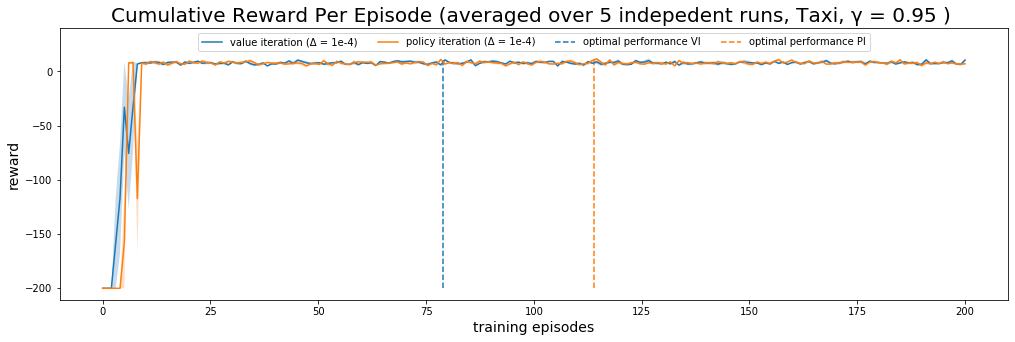

time: 321 ms


In [300]:
x=np.linspace(0, num_episodes, num_episodes)
plt.figure(figsize=(17,5))

plt.vlines(np.argmax(train_reward_mean_VI), ymin=-200, ymax=np.max(train_reward_mean_VI),linestyles='dashed',colors='#1f77b4',label='optimal performance VI')
plt.vlines(np.argmax(train_reward_mean_PI), ymin=-200, ymax=np.max(train_reward_mean_PI),linestyles='dashed',colors='#ff7f0e',label='optimal performance PI')

plt.plot(x,train_reward_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_reward_mean_VI-train_reward_var_VI/2, train_reward_mean_VI+train_reward_var_VI/2,alpha=0.25)

plt.plot(x,train_reward_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_reward_mean_PI-train_reward_var_PI/2, train_reward_mean_PI+train_reward_var_PI/2,alpha=0.25)
  
plt.title('Cumulative Reward Per Episode (averaged over 5 indepedent runs, Taxi, \u03B3 = 0.95 ) ', fontsize=20)
plt.xlabel('training episodes',fontsize=14)
plt.ylabel('reward',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=4)

plt.ylim(top=40)

plt.show()

###Timesteps to Solve Task

Similarly as above both value iteration and policy iteration are able to find efficient policies in only a few episodes, as well the variance is low in this plot as well. An interesting observation for the taxi game is that assuming the agent does not make any illegal pickup or dropoff actions, the cumulative reward for the agent is a linear function of the number of steps (taking into account the discount factor) and the reward at successful dropoff. Therefore this timesteps graph can be observed as an inverse of the cumulative reward graph above. The optimal performance points demonstrate this as they are at the exact same episode in each graph

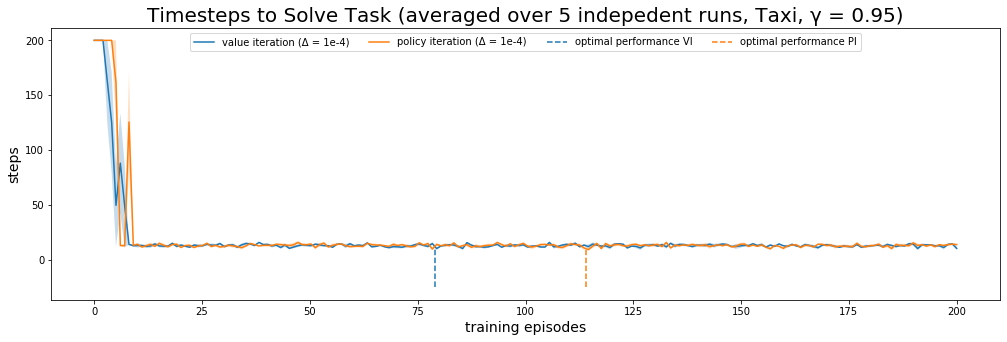

time: 315 ms


In [301]:
x=np.linspace(0, num_episodes, num_episodes)
plt.figure(figsize=(17,5))

plt.vlines(np.argmin(train_steps_mean_VI), ymin=-25, ymax=np.min(train_steps_mean_VI),linestyles='dashed',colors='#1f77b4',label='optimal performance VI')
plt.vlines(np.argmin(train_steps_mean_PI), ymin=-25, ymax=np.min(train_steps_mean_PI),linestyles='dashed',colors='#ff7f0e',label='optimal performance PI')


plt.plot(x,train_steps_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_steps_mean_VI-train_steps_var_VI/2, train_steps_mean_VI+train_steps_var_VI/2,alpha=0.25)

plt.plot(x,train_steps_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_steps_mean_PI-train_steps_var_PI/2, train_steps_mean_PI+train_steps_var_PI/2,alpha=0.25)
  
plt.title('Timesteps to Solve Task (averaged over 5 indepedent runs, Taxi, \u03B3 = 0.95)', fontsize=20)
plt.xlabel('training episodes',fontsize=14)
plt.ylabel('steps',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=4)
plt.show()

#Testing

For testing we trained each dynamic programming algorithm for 2 training episodes, then fixed the policy and played the game with that policy 5 times, averaging the rewards and number of steps taken to create our test data points. These were then averaged over 10 indepedent runs like all other figures.

As discussed on MyCourses for dynamic programming methods the test plot and the train plot convey the same information. The test plots below are included to develop a habit of reporting both training and testing information in RL experiments.

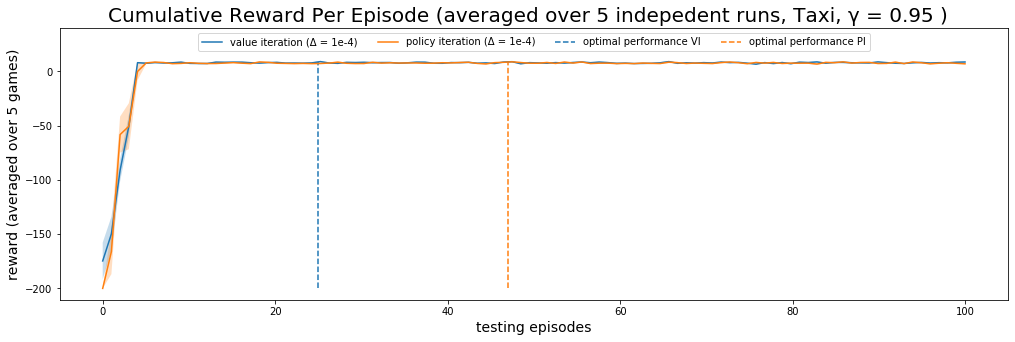

time: 319 ms


In [302]:
test_episodes = int(num_episodes/test_freq)

x=np.linspace(0, test_episodes, test_episodes)
plt.figure(figsize=(17,5))

plt.vlines(np.argmax(test_reward_mean_VI), ymin=-200, ymax=np.max(test_reward_mean_VI),linestyles='dashed',colors='#1f77b4',label='optimal performance VI')
plt.vlines(np.argmax(test_reward_mean_PI), ymin=-200, ymax=np.max(test_reward_mean_PI),linestyles='dashed',colors='#ff7f0e',label='optimal performance PI')


plt.plot(x,test_reward_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_reward_mean_VI-test_reward_var_VI/2, test_reward_mean_VI+test_reward_var_VI/2,alpha=0.25)

plt.plot(x,test_reward_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_reward_mean_PI-test_reward_var_PI/2, test_reward_mean_PI+test_reward_var_PI/2,alpha=0.25)
  
plt.title('Cumulative Reward Per Episode (averaged over 5 indepedent runs, Taxi, \u03B3 = 0.95 )  ', fontsize=20)
plt.xlabel('testing episodes',fontsize=14)
plt.ylabel('reward (averaged over 5 games)',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=4)

plt.ylim(top=40)

plt.show()

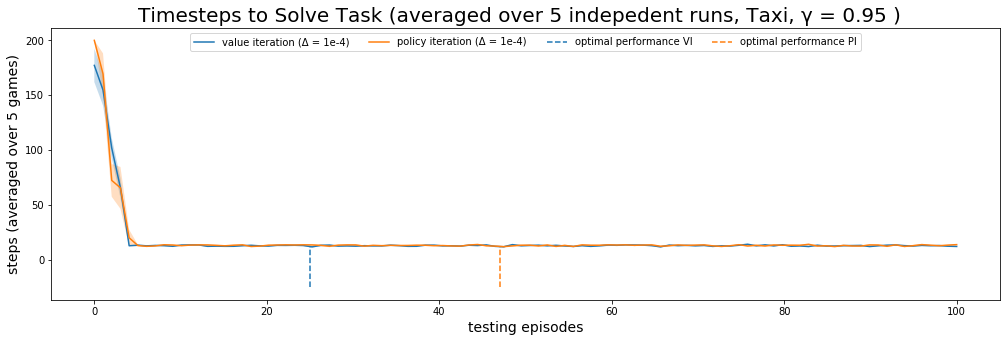

time: 400 ms


In [303]:
x=np.linspace(0, test_episodes, test_episodes)
plt.figure(figsize=(17,5))

plt.vlines(np.argmin(test_steps_mean_VI), ymin=-25, ymax=np.min(test_steps_mean_VI),linestyles='dashed',colors='#1f77b4',label='optimal performance VI')
plt.vlines(np.argmin(test_steps_mean_PI), ymin=-25, ymax=np.min(test_steps_mean_PI),linestyles='dashed',colors='#ff7f0e',label='optimal performance PI')


plt.plot(x,test_steps_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_steps_mean_VI-test_steps_var_VI/2, test_steps_mean_VI+test_steps_var_VI/2,alpha=0.25)

plt.plot(x,test_steps_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_steps_mean_PI-test_steps_var_PI/2, test_steps_mean_PI+test_steps_var_PI/2,alpha=0.25)
  
plt.title('Timesteps to Solve Task (averaged over 5 indepedent runs, Taxi, \u03B3 = 0.95 )  ', fontsize=20)
plt.xlabel('testing episodes',fontsize=14)
plt.ylabel('steps (averaged over 5 games)',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=4)
plt.show()

#Frozen Lake
A 4x4 stochastic grid (i.e. we do not always move where we want to),with fixed starting state and goal state. There are 16 possible states in this environment and 4 actions, left, right, up, down. Some of the grid spots are holes that will terminate your attempt at reaching the goal state. An episode ends when you reach the goal or fall in a hole. The agent receives a reward of 1 if the goal is reached, and 0 otherwise.

https://gym.openai.com/envs/FrozenLake-v0/

In [304]:
#our game
environment = gym.make('FrozenLake-v0')

# Number of episodes to play
num_episodes = 500
test_freq = 5

train_reward_mean_VI, train_reward_var_VI, train_steps_mean_VI, train_steps_var_VI, test_reward_mean_VI, test_reward_var_VI, test_steps_mean_VI, test_steps_var_VI = value_iteration(environment,1,1e-4,num_episodes,test_freq)
train_reward_mean_PI, train_reward_var_PI, train_steps_mean_PI, train_steps_var_PI, test_reward_mean_PI, test_reward_var_PI, test_steps_mean_PI, test_steps_var_PI = policy_iteration(environment,1,1e-4,num_episodes,test_freq)

time: 7.27 s


#Training

###Cumulative Reward Per Episode

Since the reward in the FrozenLake environment is either 0 or 1, our datapoints all fall in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] since we are averaging over 5 independent runs. Both policy iteration and value iteration appear to learn efficient policies quite quickly. The stochastic nature of the environment and the fact that we don't always move to where we specify cause the cumulative reward graph to be very noisy. I did not include a dotted line to designate optimal performance as the cumulative reward averaged over all 5 runs is frequently 1.0. The true performance of these policies is difficult to interpret from this graph, the next graph helps add some context to how the two algorithms performed with respect to reward.

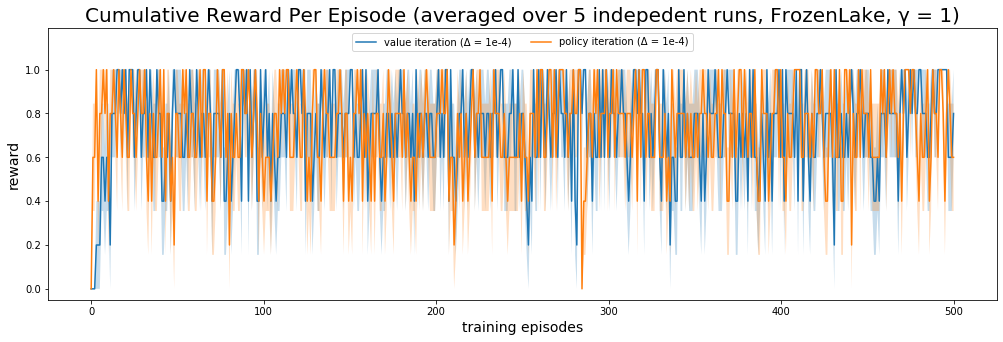

time: 408 ms


In [305]:
x=np.linspace(0, num_episodes, num_episodes)
plt.figure(figsize=(17,5))

plt.plot(x,train_reward_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_reward_mean_VI-train_reward_var_VI/2, train_reward_mean_VI+train_reward_var_VI/2,alpha=0.25)

plt.plot(x,train_reward_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_reward_mean_PI-train_reward_var_PI/2, train_reward_mean_PI+train_reward_var_PI/2,alpha=0.25)
  
plt.title('Cumulative Reward Per Episode (averaged over 5 indepedent runs, FrozenLake, \u03B3 = 1)', fontsize=20)
plt.xlabel('training episodes',fontsize=14)
plt.ylabel('reward',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)
plt.ylim(top=1.19)


plt.show()

###Average Reward Across Episodes

In the frozen lake environment our reward is 1 in success and 0 in failure. Therefore this graph of average reward can also be interpretted as our winning percentage through training. Both value and policy iteration converage to practically the exact same win percentage by episode 500. Policy iteration began winning more frequently earlier on, but value iteration caught up by episode 150. Policy iteration's winning percentage appears to plateau starting around episode 50 and value iteration around episode 150. 

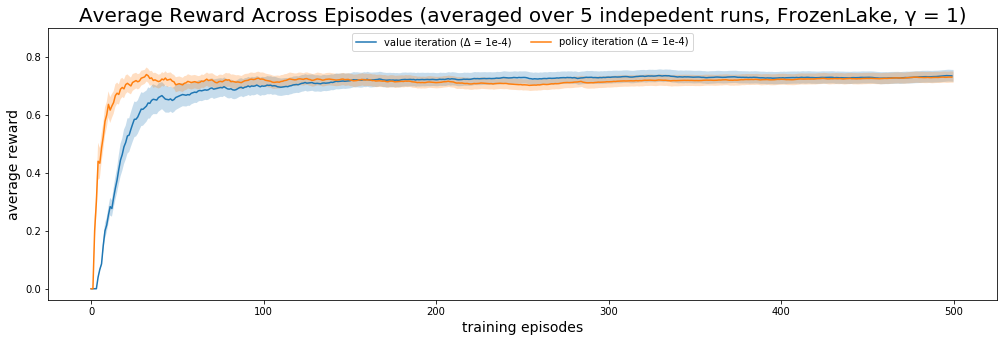

time: 339 ms


In [306]:
x=np.linspace(0, num_episodes, num_episodes)
avg = np.zeros((num_episodes))
var = np.zeros((num_episodes))
avg2 = np.zeros((num_episodes))
var2 = np.zeros((num_episodes))

for i in range(1,num_episodes):
    avg[i] = np.sum(train_reward_mean_VI[0:i])/(i+1)
    var[i] = np.var(train_reward_mean_VI[0:i])
    avg2[i] = np.sum(train_reward_mean_PI[0:i])/(i+1)
    var2[i] = np.var(train_reward_mean_PI[0:i])

plt.figure(figsize=(17,5))
plt.plot(avg,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,avg-var/2, avg+var/2,alpha=0.25)

plt.plot(avg2,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,avg2-var2/2, avg2+var2/2,alpha=0.25)


plt.title('Average Reward Across Episodes (averaged over 5 indepedent runs, FrozenLake, \u03B3 = 1)', fontsize=20)
plt.xlabel('training episodes',fontsize=14)
plt.ylabel('average reward',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)
plt.ylim(top=.9)

plt.show()

###Timesteps to Solve Task

Again due to stochastic nature of the environment this plot is very noisy. Although policy iteration and value iteration find good policies quite quickly they are still not able to control the agent perfectly in the environment due to the stochastic actions. The one significant observation from this plot is that it appears that both policy iteration and value iteration require less steps during the first few episodes, this is only because at that point they are not aware of the holes that the agent can fall into and therefore games are terminating earlier due to lack of knowledge. Once the algorithms began considering the holes, they made the agents avoid them as much as possible and therefore the agents were able to survive in the environment for longer while still trying to reach the goal state.

As a note the optimal performance lines in this graph refer to the episodes where the algorithms recieved an average reward of 1.0 (i.e. reached goal state across all 5 independent runs) while requiring the fewest number of steps

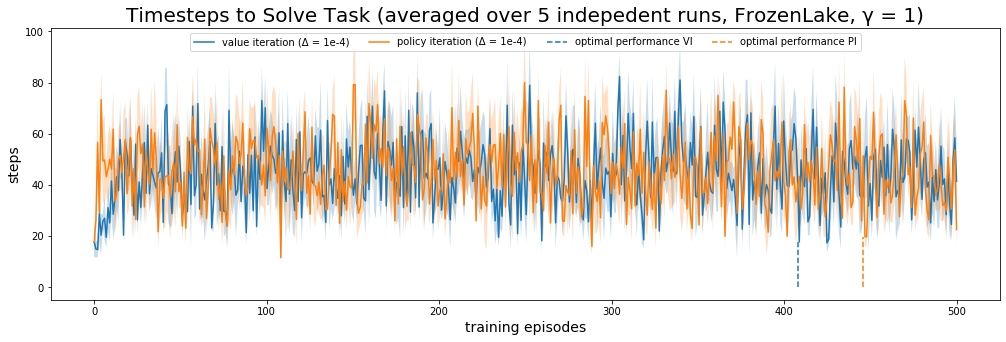

time: 471 ms


In [307]:
x=np.linspace(0, num_episodes, num_episodes)

plt.figure(figsize=(17,5))

min_VI = 1000
index_VI = -1
for i in range(num_episodes):
    if train_reward_mean_VI[i] > 0.85:
        if train_steps_mean_VI[i] < min_VI:
            min_VI = train_steps_mean_VI[i]
            index_VI = i

min_PI = 1000
index_PI = -1
for i in range(num_episodes):
    if train_reward_mean_PI[i] > 0.85:
        if train_steps_mean_PI[i] < min_PI:
            min_PI = train_steps_mean_PI[i]
            index_PI = i


plt.plot(x,train_steps_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_steps_mean_VI-train_steps_var_VI/2, train_steps_mean_VI+train_steps_var_VI/2,alpha=0.25)

plt.plot(x,train_steps_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,train_steps_mean_PI-train_steps_var_PI/2, train_steps_mean_PI+train_steps_var_PI/2,alpha=0.25)
  
plt.title('Timesteps to Solve Task (averaged over 5 indepedent runs, FrozenLake, \u03B3 = 1)', fontsize=20)
plt.xlabel('training episodes',fontsize=14)
plt.ylabel('steps',fontsize=14)

#plt.ylim(top=40)

plt.vlines(index_VI, ymin=0, ymax=min_VI,linestyles='dashed',colors='#1f77b4',label='optimal performance VI')
plt.vlines(index_PI, ymin=0, ymax=min_PI,linestyles='dashed',colors='#ff7f0e',label='optimal performance PI')

plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=4)

plt.show()

###Average Steps Across Episodes

This plot supports the observation made from the plot above. The average number of steps that policy iteration and value iteration take are directly proportional to their winning percentage over time. Value and Policy iteration are able ensure the agent distances itself as much possible from grid spaces tangent to holes, to minimize the risk of failure. This technique leads to more steps taken by the agent but also a greater success rate of reaching the goal state. Variance is excluded in this plot as the variance across the runs was so large that it filled the plot.

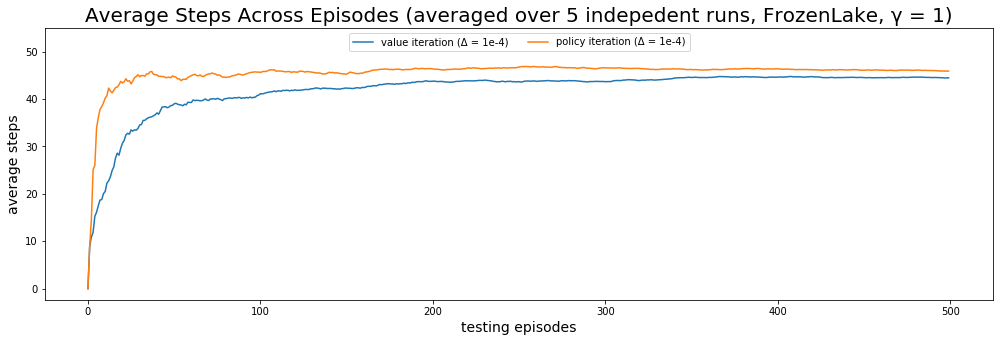

time: 328 ms


In [308]:
x=np.linspace(0, num_episodes, num_episodes)
avg = np.zeros((num_episodes))
var = np.zeros((num_episodes))
avg2 = np.zeros((num_episodes))
var2 = np.zeros((num_episodes))

for i in range(1,num_episodes):
    avg[i] = np.sum(train_steps_mean_VI[0:i])/(i+1)
    avg2[i] = np.sum(train_steps_mean_PI[0:i])/(i+1)

plt.figure(figsize=(17,5))
plt.plot(avg,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,avg-var/2, avg+var/2,alpha=0.25)

plt.plot(avg2,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,avg2-var2/2, avg2+var2/2,alpha=0.25)

plt.title('Average Steps Across Episodes (averaged over 5 indepedent runs, FrozenLake, \u03B3 = 1)', fontsize=20)
plt.xlabel('testing episodes',fontsize=14)
plt.ylabel('average steps',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)
plt.ylim(top=55)

plt.show()

##Testing Plots

For testing we trained each dynamic programming algorithm for 5 training episodes, then fixed the policy and played the game with that policy 5 times, averaging the rewards and number of steps taken to create our test data points. These were then averaged over 10 indepedent runs like all other figures.

As discussed on MyCourses for dynamic programming methods the test plot and the train plot convey the same information. The test plots below are included to develop a habit of reporting both training and testing information in RL experiments.

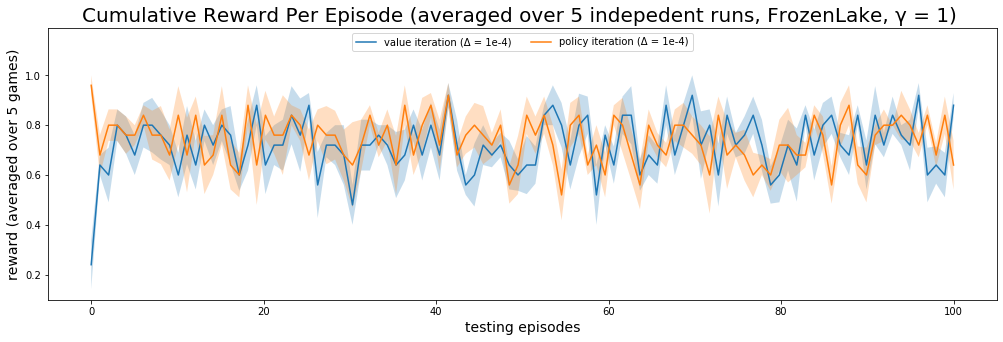

time: 324 ms


In [309]:
test_episodes = int(num_episodes/test_freq)

x=np.linspace(0, test_episodes, test_episodes)
plt.figure(figsize=(17,5))

plt.plot(x,test_reward_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_reward_mean_VI-test_reward_var_VI/2, test_reward_mean_VI+test_reward_var_VI/2,alpha=0.25)

plt.plot(x,test_reward_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_reward_mean_PI-test_reward_var_PI/2, test_reward_mean_PI+test_reward_var_PI/2,alpha=0.25)
  
plt.title('Cumulative Reward Per Episode (averaged over 5 indepedent runs, FrozenLake, \u03B3 = 1) ', fontsize=20)
plt.xlabel('testing episodes',fontsize=14)
plt.ylabel('reward (averaged over 5 games)',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)

plt.ylim(top=1.19)

plt.show()

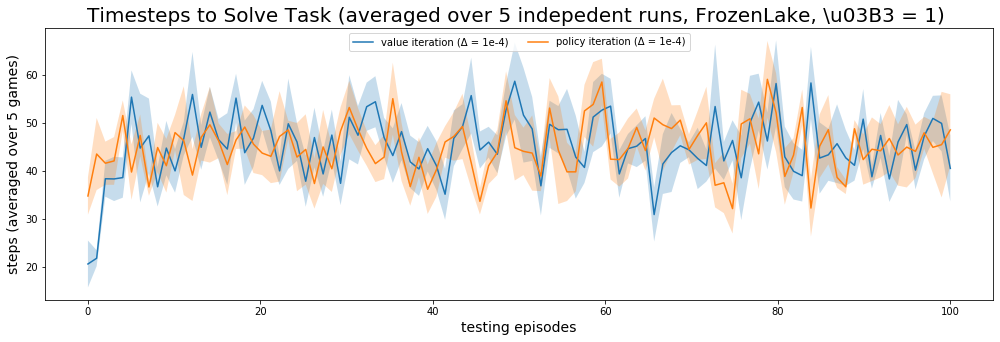

time: 341 ms


In [310]:
x=np.linspace(0, test_episodes, test_episodes)
plt.figure(figsize=(17,5))

plt.plot(x,test_steps_mean_VI,label='value iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_steps_mean_VI-test_steps_var_VI/2, test_steps_mean_VI+test_steps_var_VI/2,alpha=0.25)

plt.plot(x,test_steps_mean_PI,label='policy iteration (\u0394 = 1e-4)')
plt.fill_between(x,test_steps_mean_PI-test_steps_var_PI/2, test_steps_mean_PI+test_steps_var_PI/2,alpha=0.25)
  
plt.title(r'Timesteps to Solve Task (averaged over 5 indepedent runs, FrozenLake, \u03B3 = 1) ', fontsize=20)
plt.xlabel('testing episodes',fontsize=14)
plt.ylabel('steps (averaged over 5 games)',fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)
plt.show()

#Time complexity

For one iteration of value iteration we loop through all the states (time = $O(|S|))$ and for every state we find the action with maximum action value (time = $O(|S||A|)$). Therefore,

###Time complexity of one iteration of value iteration: $O(|S|^2|A|)$


For one iteration of policy evaluation we loop through all the states (time = $O(|S|))$ and then sum over all the possible next states under our policy (time = $O(|S|))$. Therefore one iteration of policy evaluation has time complexity $O(|S|^2)$. We run policy evaluation until convergence or until a maximum number of iterations has been completed, denote this $n$. Therefore,
the time complexity of policy evaluation is $O(n|S|^2)$

For one iteration of policy iteration, we run policy evaluation (time = $O(n|S|^2)$) and proceed to loop through all the states (time = $O(|S|))$ and for every state we find the action with maximum action value (time = $O(|S||A|)$). Therefore,

###Time complexity of one iteration of policy iteration: $O(n|S|^2| +|S|^2|A|)$

#Space Complexity

Both value iteration and policy iteration require at some point to store the policy in memory. A basic representation of the policy would require space $O(|S||A|)$. However because in value iteration and policy iteration our policy is determinisitic we could use a more efficient data structure to store the policy, for example a list of size $|S|$ that stores the index of action for each state under a policy. Therefore,

###Space complexity of value iteration: $O(|S|)$

###Space complexity of policy iteration: $O(|S|)$
